# Producing skymap-related plots

In [1]:
import numpy as np
import pathlib
from ligo.skymap import moc, io, postprocess
from astropy import units as u
sr_to_deg2 = u.sr.to(u.deg**2)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from plotting_utils import (
    psd_colours,
    psd_markers,
    psd_labels,
    psd_ls,
    get_times_array,
)
psds = list(psd_colours.keys())

plt.style.use("../paper.mplstyle")


/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_skymap_area(fits_file, levels):
    """Compute the area of the skymap

    Based on the code from ligo.skymap.
    """
    skymap = io.fits.read_sky_map(fits_file, moc=True)
    dA = moc.uniq2pixarea(skymap['UNIQ'])
    dP = skymap['PROBDENSITY'] * dA
    dP = skymap['PROBDENSITY'] * dA
    cls = 100 * postprocess.find_greedy_credible_levels(dP, skymap['PROBDENSITY'])
    i = np.flipud(np.argsort(skymap['PROBDENSITY']))
    area = np.interp(levels, cls[i], np.cumsum(dA[i]), left=0, right=4 * np.pi)
    return area * sr_to_deg2

In [3]:
skymap_path = pathlib.Path("Making_Skymaps")

Load the pre-computed fits file.

See the readme for instructions on how to produce the files.

In [4]:
fits_files = {}
for inj in range(0, 5):
    inj_key = f"injection {inj}"
    fits_files[inj_key] = {}
    for psd in psds:
        fits_files[inj_key][psd] = {}
        for time in range(1, 6):
            fits_file = skymap_path / f"injection_{inj}" / psd /f"sky_map_time_{time}.fits.gz"
            if fits_file.exists():
                fits_files[inj_key][psd][f"time {time}"] = str(fits_file)

## Figure 10

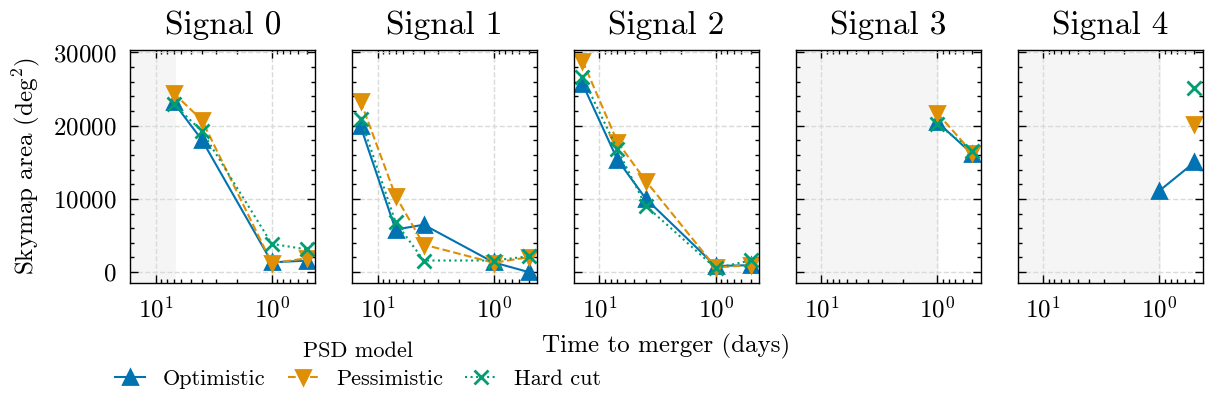

In [5]:
figsize = plt.rcParams["figure.figsize"].copy()
figsize[0] = 2 * figsize[0]
figsize[1] = 0.75 * figsize[1]

fig, axs = plt.subplots(1, 5, sharex=True, sharey="row", figsize=figsize)
for inj, inj_ff in fits_files.items():
    for psd, psd_ff in inj_ff.items():
        areas = {}
        for time, ff in psd_ff.items():
            areas[time] = compute_skymap_area(ff, [95.0])
        time_array = get_times_array(areas.keys())
        area_array = np.array(list(areas.values()))
        axs[int(inj.split(" ")[-1])].plot(
            time_array,
            area_array,
            marker=psd_markers[psd],
            c=psd_colours[psd],
            ls=psd_ls[psd]
        )

axs[0].invert_xaxis()
axs[0].set_xscale("log")

axs[0].set_ylabel(r"Skymap area (deg$^2$)")
axs[2].set_xlabel("Time to merger (days)")

for ax in [axs[3], axs[4]]:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.fill_between([1, xlims[0]], *ylims, color="whitesmoke", zorder=0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)


ax = axs[0]
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.fill_between([7, xlims[0]], *ylims, color="whitesmoke", zorder=0)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

legend_handles = [
    Line2D([0], [1], label=psd_labels[psd], ls=psd_ls[psd], marker=psd_markers[psd], c=psd_colours[psd])
    for psd in psds
]
fig.legend(
    handles=legend_handles,
    title="PSD model",
    loc="center",
    bbox_to_anchor=(0.3, -0.1),
    ncol=3
)

for i in range(5):
    axs[i].set_title(f"Signal {i}")
    axs[i].grid()

plt.show()